BERT Paper Link: arxiv.org/abs/1810.04805

In [ ]:
!pip install transformers

In [16]:
from tqdm import tqdm

import transformers
import torch
from torch import nn, optim
from torch.utils import data

import pandas as pd
import numpy as np
import copy

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

from pylab import rcParams
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette= 'muted', font_scale=1.2)

HAPPY_COLORS_PALETTE =['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 5, 5

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [6]:
from google.colab import files
uploaded = files.upload()

Saving IMDB_Dataset.csv to IMDB_Dataset.csv


In [7]:
import io
df = pd.read_csv(io.BytesIO(uploaded['IMDB_Dataset.csv']))
print(df.shape)

(50000, 2)


In [17]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the diffe

Text(0.5, 0, 'review sentiment')

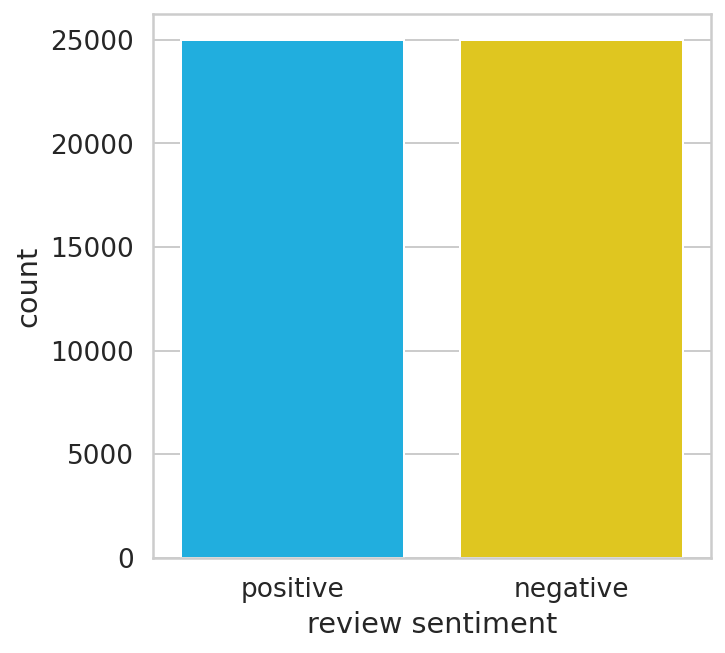

In [18]:
sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

In [20]:
df['sentimentt'] = np.where(df['sentiment'] =='positive', 1, 0)

In [22]:
pd.set_option('max_colwidth', 100)

In [23]:
df.head()

,review,sentiment,sentimentt
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,1
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive,1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,1


## Data Preprocessing

In [25]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [41]:
sample_txt = 'when was I last outside? I am stuck at home for 2 weeks.'

In [42]:
tokens = tokenizer.tokenize(sample_txt)
print(tokens)

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [43]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(sample_txt)
print(tokens)
print(token_ids)

when was I last outside? I am stuck at home for 2 weeks.
['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
[2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


## Special Tokens


In [44]:
print(f'Separation token - {tokenizer.sep_token, tokenizer.sep_token_id}')
print(f'Classification token - {tokenizer.cls_token, tokenizer.cls_token_id}')
print(f'Padding token - {tokenizer.pad_token, tokenizer.pad_token_id}')
print(f'Unknown token - {tokenizer.unk_token, tokenizer.unk_token_id}')

Separation token - ('[SEP]', 102)
Classification token - ('[CLS]', 101)
Padding token - ('[PAD]', 0)
Unknown token - ('[UNK]', 100)


In [49]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    truncation=True,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [50]:
encoding['input_ids']

tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
         2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [51]:
len(encoding['input_ids'][0])

32

In [52]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])